In [8]:
from pathlib import Path
import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd

# parameter values
p = 0.05 * ct.one_atm  # pressure
T_in = 373.0  # inlet temperature
mdot_reactants = 0.12  # kg/m^2/s
mdot_products = 0.06  # kg/m^2/s
rxnmech = 'h2o2.yaml'  # reaction mechanism file
comp = 'H2:1.6, O2:1, AR:7'  # premixed gas composition

width = 0.2  # m
loglevel = 1  # amount of diagnostic output (0 to 5)

# Set up the problem
gas = ct.Solution(rxnmech)

# set state to that of the unburned gas at the burner
gas.TPX = T_in, p, comp

# Create the flame simulation object
sim = ct.CounterflowPremixedFlame(gas=gas, width=width)

# Set grid refinement parameters
sim.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)

# set the boundary flow rates
sim.reactants.mdot = mdot_reactants
sim.products.mdot = mdot_products

sim.set_initial_guess()  # assume adiabatic equilibrium products
sim.show()

sim.solve(loglevel, auto=True)

if "native" in ct.hdf_support():
    output = Path() / "premixed_counterflow_flame.h5"
else:
    output = Path() / "premixed_counterflow_flame.yaml"
output.unlink(missing_ok=True)

sim.save(output, name="mix", description="solution with mixture-averaged transport")

# write the velocity, temperature, and mole fractions to a CSV file
sim.save("premixed_counterflow_flame.csv", basis="mole", overwrite=True)
sim.show_stats()
sim.show()



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> reactants <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Mass Flux:         0.12 kg/m^2/s 
    Temperature:        373 K 
    Mass Fractions: 
                      H2     0.01024 
                      O2      0.1016 
                      AR      0.8881 



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> flame <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Pressure:        5066 Pa

-------------------------------------------------------------------------------
          z    velocity  spread_rate           T      lambda      eField 
-------------------------------------------------------------------------------
          0        2.24           0         373      -50.19           0 
       0.06     -0.1336        17.8         373      -50.19           0 
        0.1      -1.716       29.67        1214      -50.19           0 
       0.14      -3.298        35.6        2055      -50.19           0 
        0.2      -5.671           0        2055      -50.19           0 

-------

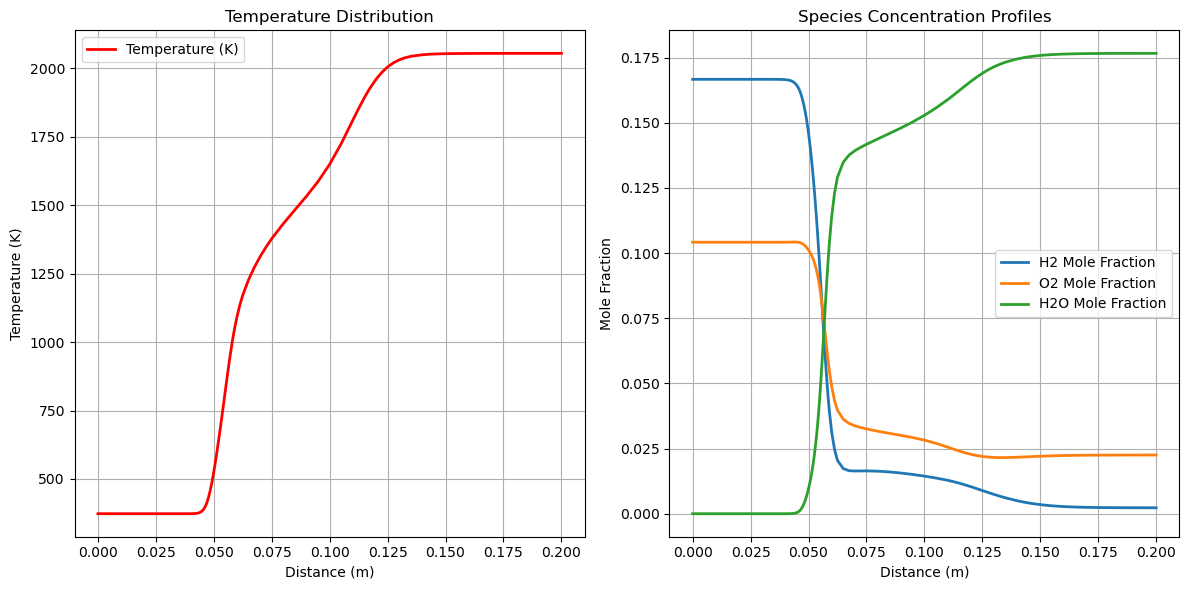

In [10]:
# CSV file save
sim.save("premixed_counterflow_flame.csv", basis="mole", overwrite=True)

# CSV file load
data = pd.read_csv("premixed_counterflow_flame.csv")

# Assign variables to the corresponding columns
distance = data["grid"]       # Distance (x-axis)
temperature = data["T"]       # Temperature (K)
h2 = data["X_H2"]             # Hydrogen (H2 mole fraction)
o2 = data["X_O2"]             # Oxygen (O2 mole fraction)
h2o = data["X_H2O"]           # Water (H2O mole fraction)

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns of subplots

# Subplot 1: Temperature distribution
axes[0].plot(distance, temperature, label="Temperature (K)", color='r', linewidth=2)
axes[0].set_xlabel("Distance (m)")
axes[0].set_ylabel("Temperature (K)")
axes[0].set_title("Temperature Distribution")
axes[0].grid()
axes[0].legend()

# Subplot 2: Species concentration profiles
axes[1].plot(distance, h2, label="H2 Mole Fraction", linewidth=2)
axes[1].plot(distance, o2, label="O2 Mole Fraction", linewidth=2)
axes[1].plot(distance, h2o, label="H2O Mole Fraction", linewidth=2)
axes[1].set_xlabel("Distance (m)")
axes[1].set_ylabel("Mole Fraction")
axes[1].set_title("Species Concentration Profiles")
axes[1].grid()
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()